### Let's Investigate Attention Sink

- Attention is allocated mostly to the first token.
- Interesting phenomenom because the first token only attends to itself (BOS token)
    - Meaning this token does not have any information


So this short notebook is here to 

- [x] Check if Attention Sink does happen.
    - [x] ALso, visualize them
- If attention sink acts to stop over-mixing. (Not Done)
    - [ ] What is the intermediate representation of first token?
    - [ ] Does the attention output differ for first token?

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [2]:
model_name = "meta-llama/Llama-3.2-1B"

In [3]:
# Load model
from transformers import AutoTokenizer, AutoModelForCausalLM

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name,
                                             output_attentions=True,  
                                            output_hidden_states=True,  
                                            torch_dtype=torch.float16,  
                                            return_dict_in_generate=True,
                                            device_map="auto"
                                            )

c:\Users\qwe40\Desktop\Attention_sink\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Random dataset
from datasets import load_dataset
ds = load_dataset("Salesforce/wikitext", "wikitext-103-raw-v1")
print(len(ds['train']['text']))


1801350


In [5]:
# just a long text
long_text = " ".join(ds['train']['text'])
print(len(long_text))

540095682


In [6]:
# random sample from long text
def get_random_text(long_text, char_len=10000):
    random_index = np.random.randint(0, len(long_text) - char_len)
    return long_text[random_index:random_index+char_len]

def get_attention_and_embeddings(input_text, tokenizer, model):

    inputs = tokenizer(input_text, return_tensors="pt")
    inputs = {k: v.to(model.device) for k, v in inputs.items()}
    
    # Forward pass
    with torch.no_grad():
        outputs = model(**inputs)
    
    attention_scores = outputs.attentions
    
    hidden_states = outputs.hidden_states
    
    return {
        'attention_scores': [score.cpu().numpy() for score in attention_scores],
        'embeddings': [hidden_state.cpu().numpy() for hidden_state in hidden_states],
        'tokenized_text': tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
    }

In [7]:
random_item = get_random_text(long_text)

In [8]:
item = get_attention_and_embeddings(random_item, tokenizer=tokenizer, model=model)

`torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True`. Falling back to eager attention. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


In [9]:
print(item['tokenized_text'][0])

<|begin_of_text|>


In [10]:
print(len(item['attention_scores'])) # number of attention layers
print(item['attention_scores'][0].shape)  # batch size, attn_head num, token, token

16
(1, 32, 1962, 1962)


Attention Scores across indices. Looks like scores are focused on the initial token and several tokens near the target token.

np.float16(3.08)

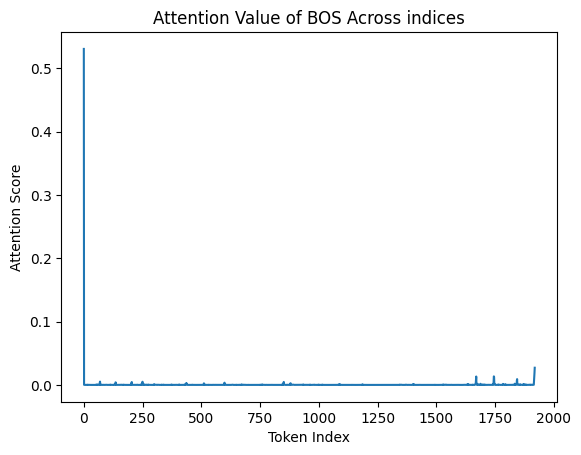

In [13]:
def graph_and_get_entropy_attn_values(attention_scores, layer, gqa_num, token_index):

    layer_attn_score = attention_scores[layer]
    layer_attn_score = layer_attn_score.squeeze()
    layer_attn_score_gqa_ind = layer_attn_score[gqa_num][token_index]
    if gqa_num == -1: # if gqa_num == -1, average attention scores across attention heads
        layer_attn_score = layer_attn_score[:,token_index]
        layer_attn_score_gqa_ind = np.average(layer_attn_score, axis=0)

    entropy = -sum([layer_attn_score_gqa_ind[i] * np.log(layer_attn_score_gqa_ind[i]) 
               for i in range(len(layer_attn_score_gqa_ind)) 
               if layer_attn_score_gqa_ind[i] > 0])
    plt.title("Attention Value of BOS Across indices")
    plt.xlabel("Token Index")
    plt.ylabel("Attention Score")
    layer_attn_score_gqa_ind_out = layer_attn_score_gqa_ind[:token_index]
    plt.plot(layer_attn_score_gqa_ind_out)
    return entropy


# play around with this
graph_and_get_entropy_attn_values(item['attention_scores'], 10, -1, 1920)



(1962,)


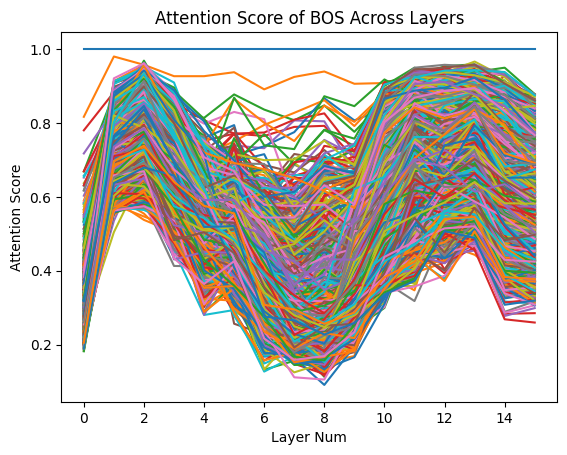

In [12]:
def plot_bos_attention(attention_score):
    items_to_plot = []
    num_layers = len(attention_score)
    colors = plt.cm.Blues(np.linspace(0.3, 1, num_layers))
    for i in range(num_layers):
        layer_attns = attention_score[i].squeeze()
        average_layer_attns = np.average(layer_attns, axis=0)
        head_attn = average_layer_attns[:, 0]
        items_to_plot.append(head_attn)
    print(items_to_plot[0].shape)
    plt.title("Attention Score of BOS Across Layers")
    plt.xlabel("Layer Num")
    plt.ylabel("Attention Score")
    plt.plot(items_to_plot)

plot_bos_attention(item['attention_scores'])
        